In [1]:
import pandas as pd
data = pd.read_excel('EURUSD (1).xlsx')

In [2]:
!unzip 'checkpoint-113560.zip'

Archive:  checkpoint-113560.zip
replace checkpoint-113560/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
import time
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.3, palette='Set2')

In [3]:
open_closed_values = data.columns[10:]

In [4]:
def find_mark(x):
    c = {} 
    for mark in x: 
        if mark < 0: 
            c[-1] = c.get(-1, 0) + 1
        elif mark == 0:
            c[0] = c.get(0, 0) + 1 
        else: 
            c[1] = c.get(1, 0) + 1
    # max_value, mark = 0, 0
    # for key, value in c.items(): 
    #     if value > max_value:
    #         max_value, mark = value, key
    return c.get(1, 0) / c.get(-1, float('inf'))

prediction = data.groupby('day_time')['mark'].apply(find_mark)

In [10]:
from statsmodels.tsa.stattools import grangercausalitytests
def run_exp(data, day_column, feature, lag, func):
    prediction = data.groupby(day_column)['mark'].apply(func)
    prediction = prediction.reset_index(drop=True)
    target = data.groupby(day_column)[feature].apply(min).fillna(0).reset_index(drop=True)
    data_for_test = pd.DataFrame({'first':prediction, 'second':target})
    return grangercausalitytests(data_for_test, lag)

run_exp(data, "day_time", "next_day_close_value", 7, sum)

/tmp/ipykernel_824344/2296210817.py:3: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  prediction = data.groupby(day_column)['mark'].apply(func)
/tmp/ipykernel_824344/2296210817.py:5: FutureWarning: The provided callable <built-in function min> is currently using np.minimum.reduce. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.minimum.reduce instead.
  target = data.groupby(day_column)[feature].apply(min).fillna(0).reset_index(drop=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5360  , p=0.0061  , df_denom=1788, df_num=1
ssr based chi2 test:   chi2=7.5486  , p=0.0060  , df=1
likelihood ratio test: chi2=7.5327  , p=0.0061  , df=1
parameter F test:         F=7.5360  , p=0.0061  , df_denom=1788, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6516  , p=0.0097  , df_denom=1785, df_num=2
ssr based chi2 test:   chi2=9.3293  , p=0.0094  , df=2
likelihood ratio test: chi2=9.3050  , p=0.0095  , df=2
parameter F test:         F=4.6516  , p=0.0097  , df_denom=1785, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6745  , p=0.0029  , df_denom=1782, df_num=3
ssr based chi2 test:   chi2=14.0787 , p=0.0028  , df=3
likelihood ratio test: chi2=14.0236 , p=0.0029  , df=3
parameter F test:         F=4.6745  , p=0.0029  , df_denom=1782, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.9219  , p=0.

{1: ({'ssr_ftest': (7.535953061691198, 0.006108496958043754, 1788.0, 1),
   'ssr_chi2test': (7.54859727823766, 0.006005680699600587, 1),
   'lrtest': (7.532734152138801, 0.006058788797049375, 1),
   'params_ftest': (7.535953061690634, 0.0061084969580455775, 1788.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.651597840928189, 0.009662353533912075, 1785.0, 2),
   'ssr_chi2test': (9.329255053514238, 0.009422757294918448, 2),
   'lrtest': (9.305027744374456, 0.009537595472610929, 2),
   'params_ftest': (4.651597840928363, 0.009662353533910933, 1785.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.6745475921451956, 0.002942595810645108, 1782.0, 3),
   'ssr_chi2test': (14.078730037622483, 0.0027999229650676315, 3),
   'lrtest': (14.023621919877769, 0.0028731749837564704, 3),
   'params_ftest': (4.674547592145432, 0.002942595810644282, 1782.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],


In [11]:
run_exp(data, "day_time", "next_day_close_value", 7, find_mark)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4594  , p=0.0631  , df_denom=1788, df_num=1
ssr based chi2 test:   chi2=3.4652  , p=0.0627  , df=1
likelihood ratio test: chi2=3.4619  , p=0.0628  , df=1
parameter F test:         F=3.4594  , p=0.0631  , df_denom=1788, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5603  , p=0.0776  , df_denom=1785, df_num=2
ssr based chi2 test:   chi2=5.1349  , p=0.0767  , df=2
likelihood ratio test: chi2=5.1276  , p=0.0770  , df=2
parameter F test:         F=2.5603  , p=0.0776  , df_denom=1785, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6467  , p=0.0476  , df_denom=1782, df_num=3
ssr based chi2 test:   chi2=7.9714  , p=0.0466  , df=3
likelihood ratio test: chi2=7.9537  , p=0.0470  , df=3
parameter F test:         F=2.6467  , p=0.0476  , df_denom=1782, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.7830  , p=0.

/tmp/ipykernel_824344/2296210817.py:5: FutureWarning: The provided callable <built-in function min> is currently using np.minimum.reduce. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.minimum.reduce instead.
  target = data.groupby(day_column)[feature].apply(min).fillna(0).reset_index(drop=True)


{1: ({'ssr_ftest': (3.459420749261034, 0.06305645352478224, 1788.0, 1),
   'ssr_chi2test': (3.4652251464913375, 0.06267197505515279, 1),
   'lrtest': (3.4618772069825354, 0.06279898167986583, 1),
   'params_ftest': (3.459420749260769, 0.06305645352478606, 1788.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.560289854371802, 0.07756611989939059, 1785.0, 2),
   'ssr_chi2test': (5.134923069272297, 0.0767300750539784, 2),
   'lrtest': (5.1275719193226905, 0.07701262113922545, 2),
   'params_ftest': (2.5602898543718218, 0.07756611989939059, 1785.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.6467231327302243, 0.047592690701450086, 1782.0, 3),
   'ssr_chi2test': (7.971359738138672, 0.046607336796347064, 3),
   'lrtest': (7.9536530721670715, 0.04697933128070457, 3),
   'params_ftest': (2.6467231327304455, 0.04759269070143958, 1782.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
         

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model
path = '../Sentiment analysis/lora_finbert_3_classes/checkpoint-107882/'

checkpoint_file = '../Sentiment analysis/lora_finbert_3_classes/checkpoint-107882/adapter_model.bin'
checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
num_of_out_classes = 3
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
sentiment_predictor = torch.nn.Linear(model.classifier.in_features, num_of_out_classes)
model.classifier = sentiment_predictor
model.num_labels = num_of_out_classes
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value", 'classifier'],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
lora_model.load_adapter(path, lora_model.active_adapter)

_IncompatibleKeys(missing_keys=['base_model.model.bert.embeddings.word_embeddings.weight', 'base_model.model.bert.embeddings.position_embeddings.weight', 'base_model.model.bert.embeddings.token_type_embeddings.weight', 'base_model.model.bert.embeddings.LayerNorm.weight', 'base_model.model.bert.embeddings.LayerNorm.bias', 'base_model.model.bert.encoder.layer.0.attention.self.query.weight', 'base_model.model.bert.encoder.layer.0.attention.self.query.bias', 'base_model.model.bert.encoder.layer.0.attention.self.key.weight', 'base_model.model.bert.encoder.layer.0.attention.self.key.bias', 'base_model.model.bert.encoder.layer.0.attention.self.value.weight', 'base_model.model.bert.encoder.layer.0.attention.self.value.bias', 'base_model.model.bert.encoder.layer.0.attention.output.dense.weight', 'base_model.model.bert.encoder.layer.0.attention.output.dense.bias', 'base_model.model.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'base_model.model.bert.encoder.layer.0.attention.output.La

In [10]:
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [11]:
text_data = TextDataset(data['article_text'])
batch_dataloader = DataLoader(text_data, 128, shuffle=False)

In [12]:
device = "cpu"

In [13]:
lora_model = lora_model.to(device)

In [197]:
def get_logit(text):
    tokenized = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt').to('cuda:1')
    with torch.inference_mode():
        logit = lora_model(**tokenized)['logits']
    return logit
logits = []
for batch in tqdm(batch_dataloader):
    logit = get_logit(batch)
    logits.extend(logit)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 322/322 [20:08<00:00,  3.75s/it]


In [ ]:
values = torch.cat(logits).view(-1, 3).cpu()

In [ ]:
name = 'prob_predicted_class'
new_data = data[['article_text', *open_closed_values]]
for i in range(3):
    new_name = name + f'_{i}'
    new_data[new_name] = values[:, i]

In [21]:
filter = new_data.article_text.apply(lambda x: 'eur/usd' in x.lower() or 'eur / usd' in x.lower())

In [22]:
filtered = new_data[filter]

In [32]:
target_open = 'next_day_open_value'
target_close = 'next_day_close_value'

In [24]:
target = np.sign(filtered[target_close] - filtered[target_open])

In [25]:
data_for_train = filtered.drop(filtered.columns[17:-3], axis=1)

In [15]:
class TSDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index].unsqueeze(-1), self.target[index]

In [ ]:
data_for_train.to_csv('training_data_3.csv', index=None, header=True)
target.to_csv('target_3.csv', index=None, header=True)

In [17]:
import pandas as pd
data_for_train = pd.read_csv('training_data.csv')

In [18]:
target = pd.read_csv('target.csv')

In [19]:
c = pd.merge(data_for_train, data, on='article_text', how='inner')

In [20]:
filter = c.article_text.apply(lambda x: 'eur/usd' in x.lower() or 'eur / usd' in x.lower())

In [21]:
c = c[filter]

In [22]:
cols = ['open_value', 'close_value', 'prev_day_open_value',
       'prev_day_close_value', 'prev_two_day_open_value',
       'prev_two_day_close_value', 'prev_three_day_open_value',
       'prev_three_day_close_value', 'prev_four_day_open_value',
       'prev_four_day_close_value', 'prev_five_day_open_value',
       'prev_five_day_close_value', 'prev_six_day_open_value',
       'prev_six_day_close_value', 'prev_seven_day_open_value',
       'prev_seven_day_close_value']
col1 = ['article_text', 'prob_predicted_class_0',
       'prob_predicted_class_1', 'prob_predicted_class_2',
       'prob_predicted_class_3', 'prob_predicted_class_4']
first, second = 'next_day_open_value', 'next_day_close_value'
x = c[[*col1, *map(lambda x: f"{x}_x", cols), 'day_time', first, second]]

In [23]:
sorted_data = x.set_index('day_time').sort_index()

In [24]:
data_for_train = sorted_data.drop('article_text', axis=1)

In [25]:
data_for_train = data_for_train.rename(dict(zip(list(map(lambda x: f"{x}_x", cols)), cols)), axis=1)

In [26]:
target = data_for_train[first] - data_for_train[second]

In [27]:
data_for_train['target'] = target

In [28]:
data_for_train = data_for_train.dropna()

In [29]:
data_for_train = data_for_train.groupby('day_time').mean().sort_index().reset_index()

In [30]:
from datetime import datetime
date_format = '%Y-%m-%d %H:%M:%S.%f'
# parsed_date = datetime.strptime(date_str, date_format)

date_index = data_for_train['day_time'].apply(lambda x: datetime.strptime(x, date_format))

In [33]:
data_for_train = data_for_train.dropna()
target = data_for_train['target']
open = data_for_train[target_open]
close = data_for_train[target_close]
data_for_train = data_for_train.drop(['day_time', 'target'], axis=1)

In [34]:
data_for_train.drop([target_close, target_open], axis=1, inplace=True)

In [35]:
from sklearn.preprocessing import MinMaxScaler
mx = MinMaxScaler()
new_d = mx.fit_transform(data_for_train)

In [36]:
target = target.values

In [37]:
import torch
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
import random

In [38]:
import torch.nn as nn
import torch.nn.functional as F
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=24):
        super().__init__()

        self.hidden_size = hidden_size

        # input_seq.shape = [16, 48, 2]
        # lstm_out.shape = [16, 48, 100]
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        # hidden_state = [2, 16, 100]
        self.linear0 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, input_seq):
        lstm_out, (hidden_state, cell_state) = self.lstm(input_seq)
        x = self.relu(self.linear0(torch.squeeze(hidden_state.permute(1, 0, 2), dim=1)))
        predictions = self.linear(x)
        return predictions
    # def forward(self, input_seq):
    #     # print(input_seq.shape)
    #     x = self.linear0(torch.squeeze(input_seq))
    #     x = self.relu(x)
    #     x = self.linear(x)
    #     x = F.log_softmax(x, dim=-1)
    #     return x

In [40]:
device = 'cpu'
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации.
    '''

    fig = plt.figure(figsize=(10, 5))
    plt.plot(history['loss'])
    plt.ylabel('Лосс')
    plt.xlabel('Эпоха')
    plt.show()

def train_ts_model(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    num_epochs=50,
):
    '''
    Функция для обучения модели и вывода лосса во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) loss на обучении ('история' обучения)
    '''

    history = defaultdict(list)
    # try:
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой 'эпохе' делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            optimizer.zero_grad()
            X_batch = X_batch.type('torch.FloatTensor').to(device)
            y_batch = y_batch.type('torch.FloatTensor').to(device)
            # print(torch.squeeze(logits, dim=1).shape, torch.squeeze(y_batch, dim=-1).shape)
            logits = model(X_batch)
            # print(logits.shape, y_batch.shape)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += np.sum(loss.detach().cpu().numpy())
        # Подсчитываем лосс и сохраням в 'историю'
        train_loss /= len(train_batch_gen)
        # with torch.no_grad():
        #     history['loss'].append(val(model, test))

        clear_output()

        # Печатаем результаты после каждой эпохи
        print('Эпоха {} из {} выполнена за {:.3f} сек.'.format(
            epoch + 1, num_epochs, time.time() - start_time))
        print('  лосс: \t{:.6f}'.format(train_loss))
        plot_learning_curves(history)
    # except :
    #     return model, history
    return model, history

Эпоха 5 из 5 выполнена за 0.079 сек.
  лосс: 	0.001799


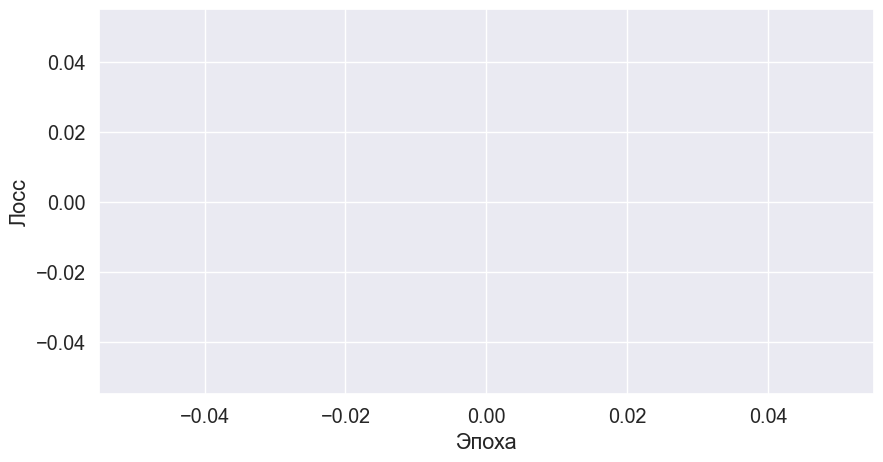

In [87]:
import random
import numpy as np
def train_val_dataset(dataset, fold, val_split=0.10, batch_size=128):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    len_dataset = int(len(dataset) * (fold + 1) / 10)
    train_len = int(len_dataset * (1 - val_split))
    val_len = len_dataset - train_len
    print(f'val_len -- {val_len}')
    print(f'train_len -- {train_len}')
    train_idx, val_idx = np.arange(train_len), np.arange(train_len, len_dataset)
    datasets = {}
    datasets['train'] = DataLoader(Subset(dataset, train_idx), batch_size, shuffle=False)
    datasets['val'] = DataLoader(Subset(dataset, val_idx), batch_size, shuffle=False)
    return datasets

from sklearn.metrics import accuracy_score, mean_squared_error

def val(model, test_batch_gen):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in test_batch_gen:
            X_batch = X_batch.type('torch.FloatTensor').cpu()
            y_batch = y_batch.type('torch.FloatTensor')
            logits = model(X_batch).cpu()
            target = np.sign(y_batch)
            prediction = np.sign(logits)
            predictions.extend(prediction)
            targets.extend(target)
    predictions = list(map(lambda x: x.item(), predictions))
    targets = list(map(lambda x: x.item(), targets))
    return accuracy_score(predictions, targets)
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)
batch_size = 10  # размер батча
accs = []
for i in tqdm(range(10)):
    train_dataset = TSDataset(torch.tensor(new_d), torch.tensor(target))
    train_test_data = train_val_dataset(train_dataset, fold=i)
    train = train_test_data['train']
    test = train_test_data['val']
    lstm_model = LSTM(input_size=1, hidden_size=64, output_size=1)
    lstm_model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.1)

    lstm_model, _ = train_ts_model(lstm_model, criterion, optimizer, train, num_epochs=5)
    with torch.no_grad():
        accs.append(val(lstm_model, test))

In [89]:
accs

[0.6111111111111112,
 0.45714285714285713,
 0.6037735849056604,
 0.39436619718309857,
 0.48863636363636365,
 0.5943396226415094,
 0.5284552845528455,
 0.5177304964539007,
 0.46835443037974683,
 0.5795454545454546]

In [90]:
# lstm w recommendations
np.mean(accs)

0.5243455402552547

In [282]:
# random walk
random_walk = np.mean([accuracy_score(np.random.choice([-1, 1], size=len(target), replace=True), np.sign(target)) for _ in range(100)])

In [283]:
random_walk

0.49890535917901935

In [ ]:
import shap
explainer = shap.DeepExplainer(lstm_model, train.dataset[:][0].type('torch.FloatTensor'))
shap_values = explainer.shap_values(test.dataset[:][0].type('torch.FloatTensor'))
# X_test_array = X_test.toarray() # w

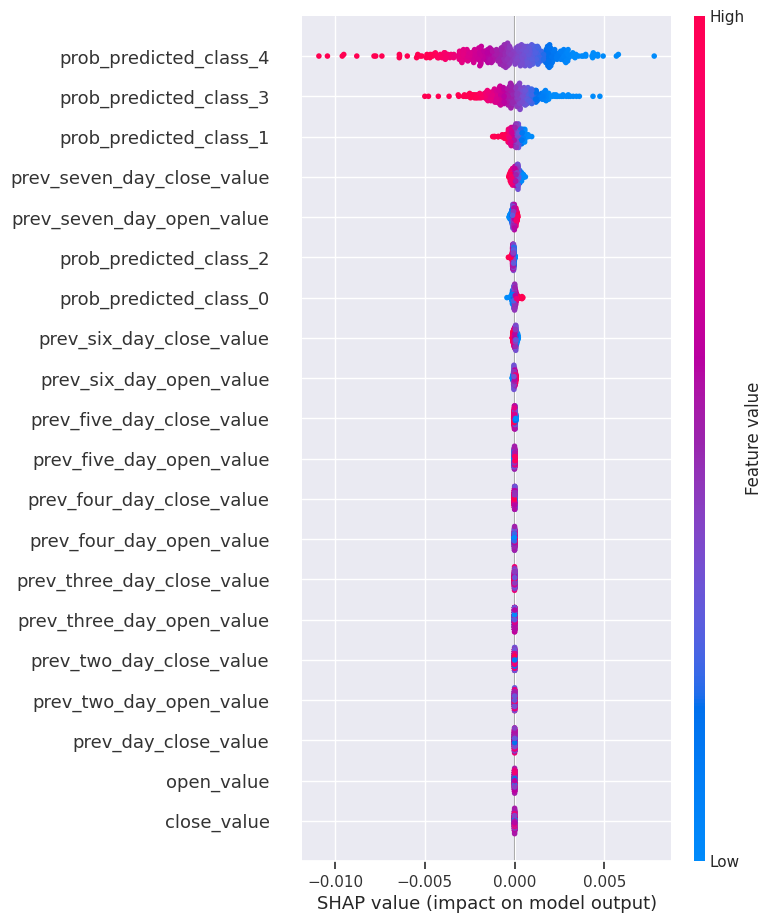

In [ ]:
shap.summary_plot(shap_values.reshape(-1, 21), test.dataset[:][0].reshape(-1, 21), feature_names=data_for_train.columns)

In [87]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [56]:
from catboost import CatBoostRegressor

In [ ]:
accs = []
for i in tqdm(range(10)):
    len_dataset = int(len(new_d) * (i + 1) / 10)
    train_size = int(len_dataset * (1 - 0.1))
    val_len = len_dataset - train_size
    x_train, y_train = new_d[:train_size], target[:train_size]
    x_test, y_test = new_d[train_size:train_size + val_len], target[train_size:train_size + val_len]
    cb = CatBoostRegressor(iterations=300, depth=16)
    cb.fit(x_train, y_train)
    accs.append(accuracy_score(np.sign(cb.predict(x_test)), np.sign(y_test)))

In [85]:
np.mean(accs)

0.535902860478631

In [86]:
accs

[0.5555555555555556,
 0.5842391238912724,
 0.5094339622641509,
 0.5601243288423694,
 0.5227272727272727,
 0.5471698113207547,
 0.45528455284552843,
 0.5460992907801419,
 0.5443037974683544,
 0.5340909090909091]

In [91]:
accs_catboost_w_recom = [0.5555555555555556,
 0.5842391238912724,
 0.5094339622641509,
 0.5601243288423694,
 0.5227272727272727,
 0.5471698113207547,
 0.45528455284552843,
 0.5460992907801419,
 0.5443037974683544,
 0.5340909090909091]

Text(0.5, 0, 'Number of day')

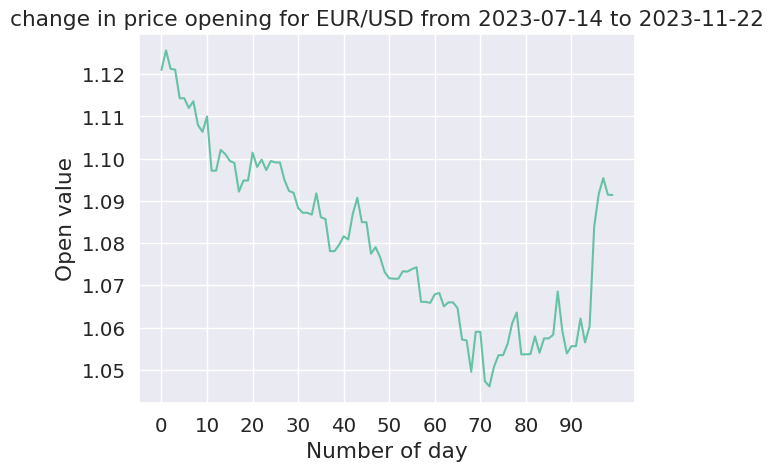

In [606]:
plt.plot(range(100), data_for_backtest['Open']);
plt.xticks(list(range(100))[::10]);
plt.title("change in price opening for EUR/USD from 2023-07-14 to 2023-11-22")
plt.ylabel("Open value")
plt.xlabel("Number of day")

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
k = 100
w = 99
idx = date_index[-k:]
data_for_backtest = pd.DataFrame(zip(open[-k:],close[-k:]), columns=["Open", "Close"])
data_for_backtest["Prediction"] = cb1.predict(x_test[-k:])
data_for_backtest["Low"] = data_for_backtest["High"] = data_for_backtest["Open"]
data_for_backtest = data_for_backtest.set_index(idx)

class SmaCross(Strategy):
    def init(self):
        pred = data_for_backtest.Prediction
        self.pred = self.I(lambda x: x > 0, pred)

    def next(self):
        if self.pred[-1]:
            self.sell()
        else:
            self.buy()
        


bt = Backtest(data_for_backtest.drop("Prediction", axis=1), SmaCross, cash=1000000, commission=0, trade_on_close=False, exclusive_orders=True)

output = bt.run()
output

In [589]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
k = 100
w = 99
idx = date_index[-k:]
data_for_backtest = pd.DataFrame(zip(open[-k:],close[-k:]), columns=["Open", "Close"])
data_for_backtest["Prediction"] = cb.predict(x_test[-k:])
data_for_backtest["Low"] = data_for_backtest["High"] = data_for_backtest["Open"]
data_for_backtest = data_for_backtest.set_index(idx)

class SmaCross(Strategy):
    def init(self):
        pred = data_for_backtest.Prediction
        self.pred = self.I(lambda x: x > 0, pred)

    def next(self):
        if self.pred[-1]:
            self.sell()
        else:
            self.buy()
        


bt = Backtest(data_for_backtest.drop("Prediction", axis=1), SmaCross, cash=1000000, commission=0., trade_on_close=False, exclusive_orders=True)

output = bt.run()
output

Start                     2023-07-14 00:00:00
End                       2023-11-22 00:00:00
Duration                    131 days 00:00:00
Exposure Time [%]                        98.0
Equity Final [$]                1119893.74226
Equity Peak [$]                 1128121.20158
Return [%]                          11.989374
Buy & Hold Return [%]               -2.832735
Return (Ann.) [%]                   33.022646
Volatility (Ann.) [%]               10.274691
Sharpe Ratio                          3.21398
Sortino Ratio                        9.650937
Calmar Ratio                        24.036586
Max. Drawdown [%]                   -1.373849
Avg. Drawdown [%]                   -0.596675
Max. Drawdown Duration       25 days 00:00:00
Avg. Drawdown Duration        6 days 00:00:00
# Trades                                   98
Win Rate [%]                        52.040816
Best Trade [%]                       2.219141
Worst Trade [%]                     -0.869427
Avg. Trade [%]                    

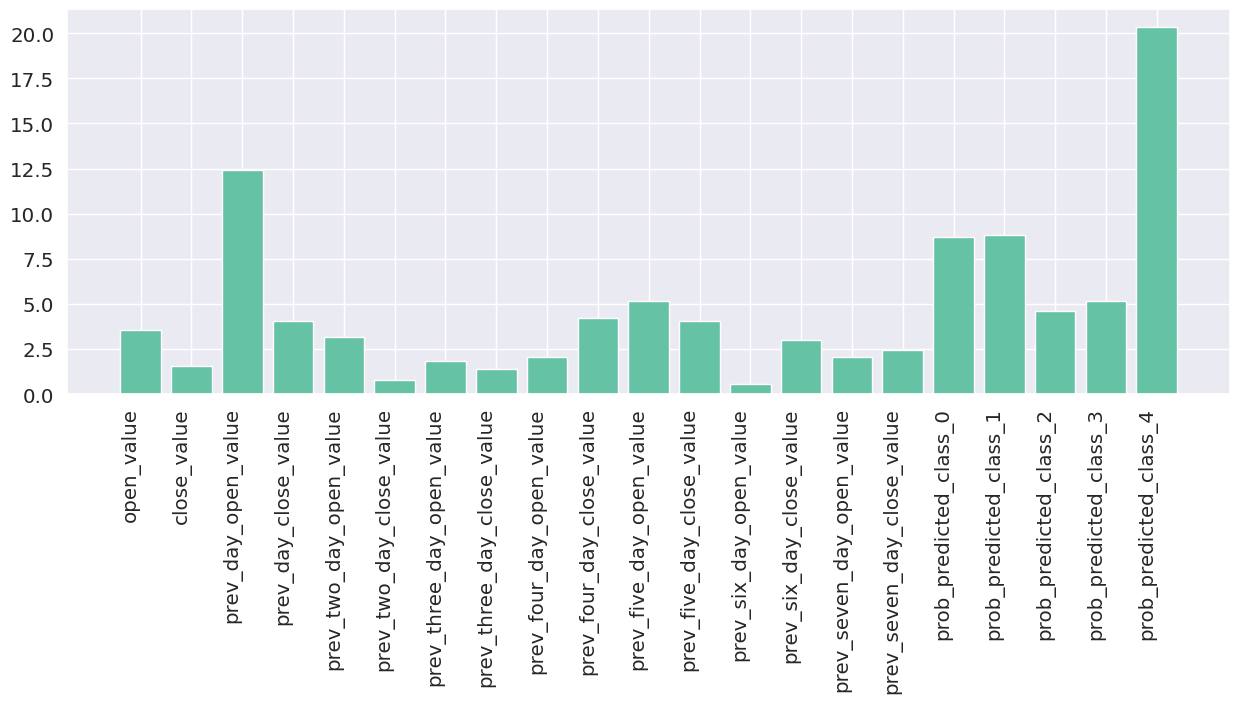

In [95]:
def visualize_catboost_coefficients(classifier, feature_names):
    coef = classifier.get_feature_importance()
    plt.figure(figsize=(15, 5))
    feature_names = np.array(feature_names)
    plt.bar(np.arange(len(feature_names)), coef)
    plt.xticks(
        np.arange(0, len(feature_names)),
        feature_names,
        rotation=90,
        ha="right",
    );

visualize_catboost_coefficients(cb, data_for_train.columns)

In [ ]:
explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(x_test)

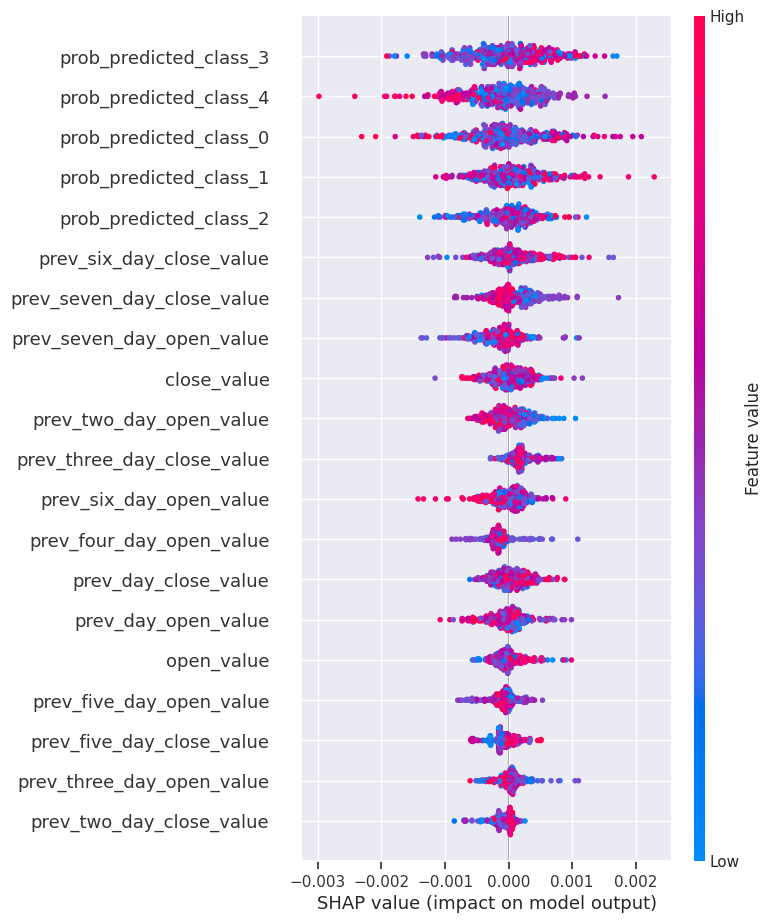

In [ ]:
shap.summary_plot(shap_values, x_test, feature_names=data_for_train.columns)

In [92]:
wo_analytics_data_for_train = data_for_train.drop([f'prob_predicted_class_{i}' for i in range(5)], axis=1)

In [93]:
wo_mx = MinMaxScaler()
wo_new_d = wo_mx.fit_transform(wo_analytics_data_for_train)

In [ ]:
accs_catboost_wo_recom = []
for i in tqdm(range(1, 10)):
    len_dataset = int(len(new_d) * (i + 1) / 10)
    train_size = int(len_dataset * (1 - 0.1))
    val_len = len_dataset - train_size
    x_train_wo, y_train_wo = wo_new_d[:train_size], target[:train_size]
    x_test_wo, y_test_wo = wo_new_d[train_size:train_size + val_len], target[train_size:train_size + val_len]
    cb = CatBoostRegressor(iterations=100, depth=10)
    cb.fit(x_train_wo, y_train_wo)
    accs_catboost_wo_recom.append(accuracy_score(np.sign(cb.predict(x_test_wo)), np.sign(y_test_wo)))

In [96]:
np.mean(accs_catboost_wo_recom)

0.4599030713683984

In [97]:
accs_catboost_wo_recom

[0.4857142857142857,
 0.37735849056603776,
 0.38028169014084506,
 0.5227272727272727,
 0.4528301886792453,
 0.43089430894308944,
 0.5177304964539007,
 0.5,
 0.4715909090909091]

Эпоха 5 из 5 выполнена за 0.069 сек.
  лосс: 	0.000682


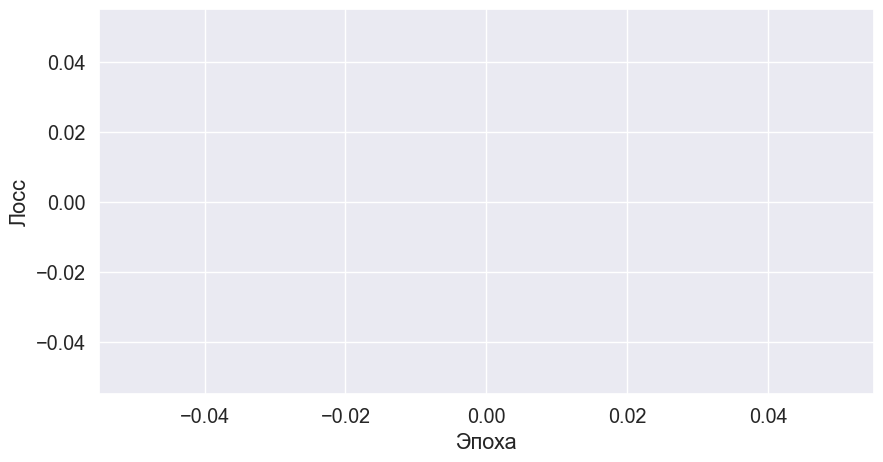

In [98]:
batch_size = 10  # размер батча
accs_lstm_wo_recom = []
for i in tqdm(range(10)):
    train_dataset = TSDataset(torch.tensor(wo_new_d), torch.tensor(target))
    train_test_data = train_val_dataset(train_dataset, fold=i)
    train = train_test_data['train']
    test = train_test_data['val']
    wo_analytics_lstm_model = LSTM(input_size=1, hidden_size=64, output_size=1)
    wo_analytics_lstm_model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(wo_analytics_lstm_model.parameters(), lr=0.1)

    lstm_model, _ = train_ts_model(wo_analytics_lstm_model, criterion, optimizer, train, num_epochs=5)
    with torch.no_grad():
        accs_lstm_wo_recom.append(val(wo_analytics_lstm_model, test))

In [99]:
np.mean(accs_lstm_wo_recom)

0.5106307146605396

In [100]:
accs_lstm_wo_recom

[0.6111111111111112,
 0.5428571428571428,
 0.6037735849056604,
 0.39436619718309857,
 0.5113636363636364,
 0.4056603773584906,
 0.4715447154471545,
 0.5177304964539007,
 0.46835443037974683,
 0.5795454545454546]

In [102]:
from scipy.stats import ttest_ind, ttest_1samp

In [284]:
catboost_w_recom_stat = ttest_1samp(accs_catboost_w_recom, random_walk, alternative='greater')
catboost_wo_recom_stat = ttest_1samp(accs_catboost_wo_recom, random_walk, alternative='greater')
lstm_wo_recom_stat = ttest_1samp(accs_lstm_wo_recom, random_walk, alternative='greater')
lstm_w_recom_stat = ttest_1samp(accs, random_walk, alternative='greater')

In [285]:
catboost_w_recom_stat.pvalue

0.004272352012710818

In [286]:
catboost_wo_recom_stat.pvalue

0.9679944029270777

In [287]:
lstm_wo_recom_stat.pvalue

0.3194089700178739

In [288]:
lstm_w_recom_stat.pvalue

0.14881761995121687